**Business Undertanding**

**Data Understanding**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [3]:
data['price'].median()

450000.0

**Data Preparation**: Data Cleaning

Previewing the data I can see there are some null values I'll have to deal with. These are coming from year renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely. 

For Waterfront and View: 
 - There are only 146 houses that are coded as waterfront. I am going to fill the null values to 0 since it won't affect the distribution much 
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature because there are a lot of reasons it could/could not have been viewed a given number of times. I am going to fill these nulls with a 0 assuming they were not available to view.

In [4]:
data['waterfront'].fillna(0.0, inplace=True)
data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [5]:
data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in data.index:
    if data['yr_renovated'][row] != 0.0:
        data['is_renovated'][row] = 1

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [6]:
data['sqft_basement'] = data['sqft_basement'].map(lambda x: x.replace("?", "0"))
data['sqft_basement'] = pd.to_numeric(data['sqft_basement'], downcast='integer')

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that costs only $640k.

In [7]:
data.drop(data.index[15856], inplace=True)

***Data Preparation***: Checking for multicollinearity, normalizing, scaling, encoding categorical data

First I'm going to separate my continuous from categorical columns. I am excluding ID, date and the sqft 15 columns for now. The dates are all from the same 2 years so there isn't a diverse amount of data and the neighboring house info is not relevant now but I could bring it in later.

In [8]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
geo_cols= ['lat', 'long']
y = data['price']
X_cols = data[cat_cols + con_cols + geo_cols]

Then I'm going to run a few visual techniques to take a look at my data and decide where I can clean it up for modeling. 

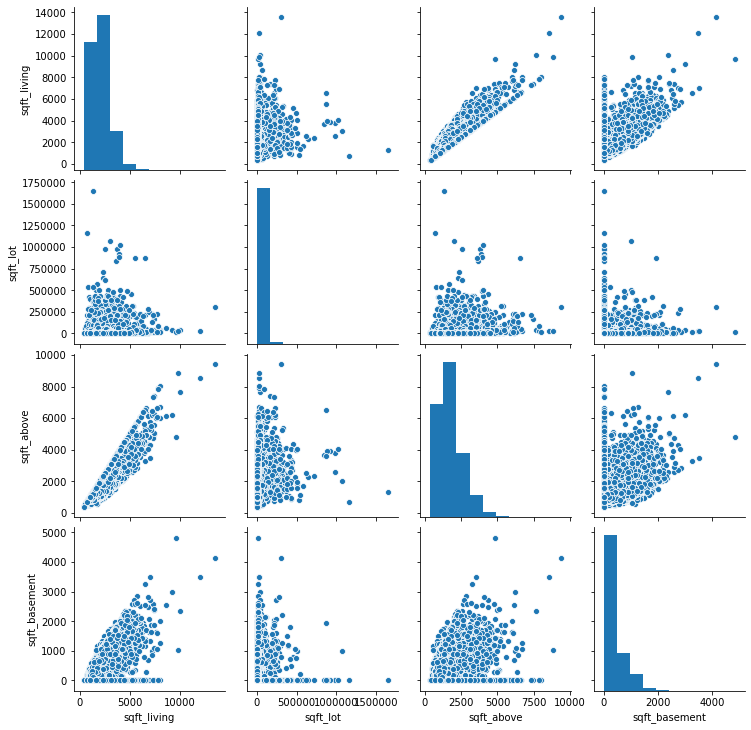

In [9]:
sns.pairplot(data[con_cols])

In [10]:
# sns.pairplot(data[cat_cols])

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


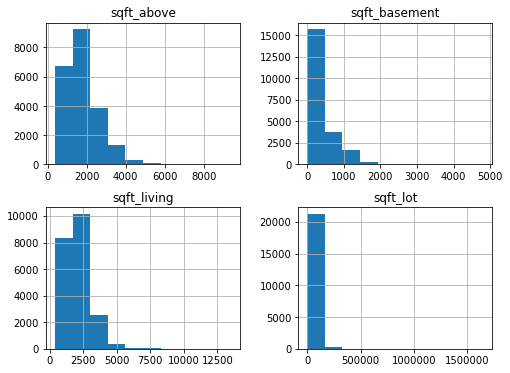

In [11]:
# use a GCA plot to look at histograms of the continuous variables
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
data[con_cols].hist(ax = ax);


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


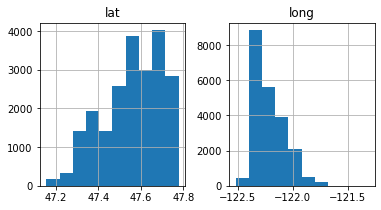

In [12]:
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
data[geo_cols].hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them. 

(18, 0)

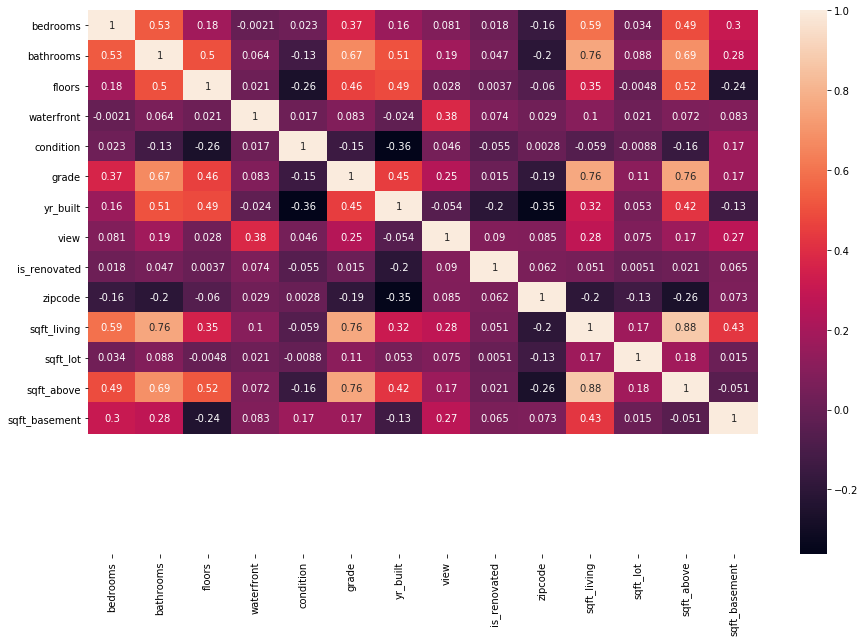

In [13]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(data[cat_cols + con_cols].corr(), annot=True)
ax.set_ylim(18,0)

I can see that some features have high correlations: Bathrooms + sqft, grade & sqft, sqft above and sqft living

**First Model**

I'm going to go ahead and model my data to see what happens. I'll use the scikitlern method, create a train test split, scale the data, and fit it to a model.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, y, test_size=0.3, random_state=20)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

In [18]:
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [19]:
coefficients = linreg.coef_
coefficients = abs(coefficients)
coef_dict = dict(list(zip(X_cols.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
grade,115779.362608
sqft_above,92686.064244
lat,84841.898012
yr_built,79095.917116
sqft_living,76405.581568
waterfront,49244.418763
view,46018.210825
bedrooms,35740.034473
bathrooms,34873.638155
sqft_basement,33281.244021


These are pretty high coefficients but now I have a better understanding of what to prioirtize. Grade, sqft on the upper part of the house, latitude, and year built are all influential factors

In [20]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print('Train Root Mean Squarred Error:', train_rmse)
print('Test Root Mean Squarred Error:', test_rmse)
print(f'train r2: {r2_score(y_train, y_hat_train)}')
print(f'test r2: {r2_score(y_test, y_hat_test)}')

Train Mean Squarred Error: 41399564395.11086
Test Mean Squarred Error: 38634665984.12906
Train Root Mean Squarred Error: 203468.8290503262
Test Root Mean Squarred Error: 196557.02985171773
train r2: 0.7005339627471194
test r2: 0.6964788014790179


the test error is not worse than the train error, but they're both huge.

In [23]:
print(f'train r2: {r2_score(y_train, y_hat_train)}')
print(f'test r2: {r2_score(y_test, y_hat_test)}')

train r2: 0.7005339627471194
test r2: 0.6964788014790179


The R2 score is not terrible but there is a LOT of error. Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with log transforming the continuous variables, since all look non-normal
and then address the multicollinearity.

**Second Model & Evaluation**

In [24]:
# log features
log_names = [f'{column}_log' for column in data[con_cols].columns]

X_con_cols_log = np.log1p(data[con_cols])
X_con_cols_log.columns = log_names
#x cols log is now a dataframe of logged continuous variables

Since latitude and longitude do not respond well to log transformations given the negative values, I am going to use a different technique with the normalization formula. 

In [25]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

geo_cols_norm = data[geo_cols].apply(normalize)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


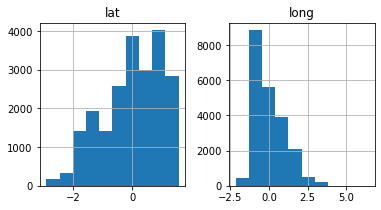

In [26]:
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
geo_cols_norm.hist(ax = ax);

These look slightly better but still not great. I'm going to run a model again to see if these techniques improved anything but first I have to concatenate my newly transformed columns into one dataframe. 

In [27]:
# import plotly.express as px
# px.scatter_geo(data_frame=data, lat='lat', lon='long')

In [28]:
new_X = pd.concat([geo_cols_norm, X_con_cols_log, data[cat_cols]], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled_2 = scaler.transform(X_train)
X_test_scaled_2 = scaler.transform(X_test)
linreg = LinearRegression()
model2 = linreg.fit(X_train_scaled_2, y_train)

In [30]:
y_hat_train = linreg.predict(X_train_scaled_2)
y_hat_test = linreg.predict(X_test_scaled_2)

In [31]:
# print(f'Train Mean Squarred Error: {mean_squared_error(y_train, y_hat_train)}')
# print(f'Test Mean Squarred Error: {mean_squared_error(y_test, y_hat_test)}')
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 215661.20367154616
Test Root Mean Squarred Error: 207260.45161449898
Train R2: 0.6635691182311435
Test R2: 0.6625225593813135


So this model actually looks worse. I'm going to use the normalize feature on everything and see if that helps.

In [41]:
con_cols_norm = data[con_cols].apply(normalize)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


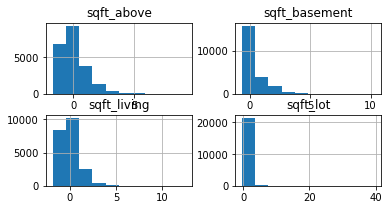

In [43]:
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
con_cols_norm.hist(ax = ax);

In [42]:
new_X = pd.concat([geo_cols_norm, con_cols_norm, data[cat_cols]], axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled_2 = scaler.transform(X_train)
X_test_scaled_2 = scaler.transform(X_test)
linreg = LinearRegression()
model2 = linreg.fit(X_train_scaled_2, y_train)

In [45]:
y_hat_train = linreg.predict(X_train_scaled_2)
y_hat_test = linreg.predict(X_test_scaled_2)

In [46]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 203468.8290503262
Test Root Mean Squarred Error: 196557.0298517178
Train R2: 0.7005339627471194
Test R2: 0.6964788014790178


My errors are lower and my R2 is higher. Normalization seems to be a better tactic than log transformation. My train R2 score is still slightly higher than my test though. 

Next I'm going to address multicolinearity. 

In [32]:
# coefficients = linreg.coef_
# coefficients = abs(coefficients)
# coef_dict = dict(list(zip(X_cols.columns, coefficients)))
# coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
# coef_df.sort_values(by=[0], ascending=False)

,0
sqft_lot,165442.765471
condition,121163.101543
sqft_above,95274.106802
bedrooms,82815.361188
view,70369.251935
sqft_basement,53328.950396
zipcode,51443.582466
grade,45319.440870
floors,42797.887355
long,29920.639494


As a reminder, these features have high correlations: Bathrooms + sqft, grade & sqft, sqft above and sqft living

In [33]:
# data.loc[data['sqft_basement'] == 0]

First I want to address the sqft columns since they will have overlapping info:

* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement

Looking at the coefficients, sqft_living is on the lower end, and has high correlation with sqft_above. I'm going to remove this column from the model and use the other three which contain all the square footage info separately. 

In [48]:
new_X = new_X.drop(['sqft_living'], axis=1)

In [53]:
new_X.corr() > 0.75

,lat,long,sqft_lot,sqft_above,sqft_basement,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,view,is_renovated,zipcode
lat,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


that takes care of everything except grade & sqft above. I'll come back to that. Now time to address categoricals. 

In [55]:
data[cat_cols].describe()

,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,view,is_renovated,zipcode
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,3.371828,2.115843,1.494119,0.006761,3.409752,7.657946,1971.000787,0.233191,0.034451,98077.950685
std,0.904114,0.768998,0.539685,0.081946,0.650471,1.173218,29.375460,0.764689,0.182388,53.514040
min,1.000000,0.500000,1.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,0.000000,98001.000000
25%,3.000000,1.750000,1.000000,0.000000,3.000000,7.000000,1951.000000,0.000000,0.000000,98033.000000
50%,3.000000,2.250000,1.500000,0.000000,3.000000,7.000000,1975.000000,0.000000,0.000000,98065.000000
75%,4.000000,2.500000,2.000000,0.000000,4.000000,8.000000,1997.000000,0.000000,0.000000,98118.000000
max,11.000000,8.000000,3.500000,1.000000,5.000000,13.000000,2015.000000,4.000000,1.000000,98199.000000


In [80]:
sorted(list(data['yr_built'].unique()))

[1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1908,
 1909,
 1910,
 1911,
 1912,
 1913,
 1914,
 1915,
 1916,
 1917,
 1918,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [72]:
# sorted(list(data['zipcode'].unique()))

[98001,
 98002,
 98003,
 98004,
 98005,
 98006,
 98007,
 98008,
 98010,
 98011,
 98014,
 98019,
 98022,
 98023,
 98024,
 98027,
 98028,
 98029,
 98030,
 98031,
 98032,
 98033,
 98034,
 98038,
 98039,
 98040,
 98042,
 98045,
 98052,
 98053,
 98055,
 98056,
 98058,
 98059,
 98065,
 98070,
 98072,
 98074,
 98075,
 98077,
 98092,
 98102,
 98103,
 98105,
 98106,
 98107,
 98108,
 98109,
 98112,
 98115,
 98116,
 98117,
 98118,
 98119,
 98122,
 98125,
 98126,
 98133,
 98136,
 98144,
 98146,
 98148,
 98155,
 98166,
 98168,
 98177,
 98178,
 98188,
 98198,
 98199]

In [58]:
data['zipcode'].head()

0    98178
1    98125
2    98028
3    98136
4    98074
Name: zipcode, dtype: int64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled_3 = scaler.transform(X_train)
X_test_scaled_3 = scaler.transform(X_test)
linreg = LinearRegression()
model3 = linreg.fit(X_train_scaled_3, y_train)

In [50]:
y_hat_train = linreg.predict(X_train_scaled_3)
y_hat_test = linreg.predict(X_test_scaled_3)

In [51]:
# print(f'Train Mean Squarred Error: {mean_squared_error(y_train, y_hat_train)}')
# print(f'Test Mean Squarred Error: {mean_squared_error(y_test, y_hat_test)}')
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 203571.2172918064
Test Root Mean Squarred Error: 196839.81062272665
Train R2: 0.7002324962689852
Test R2: 0.6956048393611697


In [39]:
# work on categoricals - zip codes, binary indicator for basement?